# 1 - The supply chain graph

In [109]:
import bw2data as bd
import pandas as pd

The first thing to learn about `bw2data` is the concept of projects. Each project is self-contained, and independent of other projects. Each has its own subdirectory. This can lead to data duplication, but helps keep each project safe from the changes in the others.

We start in the `default` project:

In [110]:
bd.projects.current

'supply chain graph'

It has its own directory:

In [111]:
bd.projects.dir

PosixPath('/home/jupyter-cmutel/.local/share/Brightway3/supply-chain-graph.d65784b9')

Make it easy to reset this project:

In [112]:
try:
    bd.projects.delete_project("supply chain graph", True)
except ValueError:
    pass

Let's create a new project:

In [113]:
bd.projects.set_current("supply chain graph")

A graph can have nodes of any type, but for the purposes of LCA it is convenient to separate activity nodes, product nodes, elementary flow nodes, and characterization nodes. We will also use a shortcut (for now) and assume that each activity produces exactly one product, so we can collapse activity and products nodes into a single node.

Let's think about a simple product system - a bike. Here is a graph:

<img src='images/simple-graph.png' width='400'>

To enter this data into BW, we need to create the nodes, and then the edges. We will create these nodes in a `Database`. A database in BW is just a collection of nodes - it can be large or small, there aren't any general rules.

In [114]:
db = bd.Database("bike")
# Let the metadata system know this database exists. Not necessary if using a `bw2io` importer.
db.register()

Our first node. We specify some additional data to make it easier to find or use this node later on.

In [115]:
data = {
    'code': 'bike',
    'name': 'bike production',
    'location': 'DK',
    'unit': 'bike'
}

bike = db.new_node(**data)
bike.save()

In [116]:
data = {
    'code': 'ng',
    'name': 'natural gas production',
    'location': 'NO',
    'unit': 'MJ'
}

ng = db.new_node(**data)
ng.save()

In [117]:
data = {
    'code': 'cf',
    'name': 'carbon fibre production',
    'location': 'DE',
    'unit': 'kg'
}

cf = db.new_node(**data)
cf.save()

We can also define nodes like this. Note that this node has a `type`.

In [118]:
co2 = db.new_node(
    code='co2', 
    name="Carbon Dioxide", 
    categories=('air',),
    type='emission',
    unit='kg'
)

co2.save()

We also need to create edges between the nodes. We can do this in many ways, here is one:

In [119]:
bike.new_edge(
    amount=2.5, 
    type='technosphere',
    input=cf
).save()

In [120]:
db.delete_duplicate_exchanges?

Signature: db.delete_duplicate_exchanges(fields=['amount', 'type'])
Docstring:
Delete exchanges which are exact duplicates. Useful if you accidentally ran your input data notebook twice.

To determine uniqueness, we look at the exchange input and output nodes, and at the exchanges values for fields ``fields``.
File:      /opt/tljh/user/envs/bw25update/lib/python3.12/site-packages/bw2data/backends/base.py
Type:      method

What about some uncertainty? We use [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) to model probability distribution functions.

In [121]:
import stats_arrays as sa

In [122]:
cf.new_edge(
    amount=237.3,  # plus 58 kWh of electricity, in ecoinvent 3.8 
    uncertainty_type=sa.TriangularUncertainty.id, 
    minimum=200, 
    maximum=300, 
    type='technosphere',
    input=ng,
).save()

In [123]:
cf.new_edge(
    amount=26.6, 
    uncertainty_type=sa.TriangularUncertainty.id, 
    minimum=26,
    maximum=27.2, 
    type='biosphere',
    input=co2,
).save()

Brightway will assume that the a `production` exchange of amount 1 in each node unless you tell it otherwise.

# Exercise

Create a new bicycle made of steel. You will need some coal and some iron ore mining for the steel, and some steel for the bicycle.

Your use of steel consumed some iron ore, a natural resource. In a **new database**, create a biosphere flow for this iron ore, and add the iron ore flow. You might not be sure about the numbers - you can reflect that in the uncertainty you assign to the exchanges.

## LCIA

To define characterization nodes and edges, we use a different data structure:

In [27]:
ipcc = bd.Method(('IPCC',))
ipcc.write([
    (co2.key, {'amount': 1, 'uncertainty_type': 3, 'loc': 1, 'scale': 0.05}),
])

This is already enough to do an LCA. Let's check what our answer should be. Without uncertainty, to make one bike we need 2.5 kg of CF, and carbon fibre produces 26.6 kg CO2 per kg of carbon fibre, so we are looking for around 60 kg CO2-eq.

In [28]:
import bw2calc as bc

In [43]:
lca = bc.LCA(demand={bike: 1}, method=('IPCC',))
lca.lci()
lca.lcia()
lca.score

66.50000095367433

To use uncertainty, we tell the `LCA` object to use the probability distributions:

In [54]:
a = "abcdefghijklmnop"
b = [1,2,3,4,5,6]

for x, y in zip(a, b):
    print(x, y)

a 1
b 2
c 3
d 4
e 5
f 6


In [74]:
next(lca)
lca.characterized_inventory.sum(), lca.score

(62.109497098046106, 62.109497098046106)

In [76]:
results = []

for x in range(20):
    next(lca)
    results.append(lca.score)

results

[68.7290915167224,
 60.00878708070435,
 67.47382677035236,
 69.82035010084925,
 63.87868317001495,
 69.78298660391235,
 70.55004161338967,
 67.18638916264896,
 69.47399463915848,
 70.33528809371815,
 68.15320172397286,
 65.13259734886735,
 68.77026085772835,
 64.01980903781158,
 65.99567310142977,
 67.84490048122242,
 70.70969401749186,
 72.66845365697775,
 64.21242006558977,
 67.08766391693216]

array([[<Axes: title={'center': 'score'}>]], dtype=object)

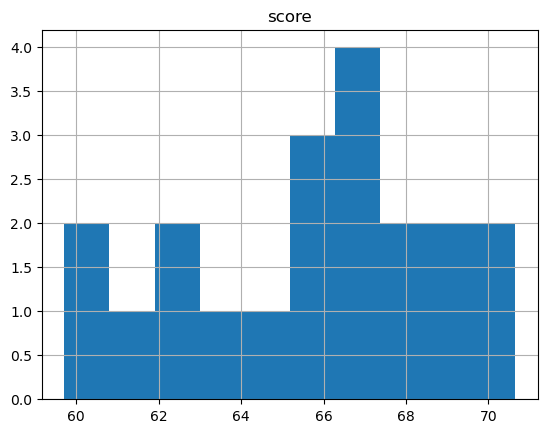

In [52]:
lca = bc.LCA(demand={bike: 1}, method=('IPCC',), use_distributions=True)
lca.lci()
lca.lcia()

df = pd.DataFrame([{'score': lca.score} for _ in zip(lca, range(20))])
df.hist()

## Exercise

Create a new LCIA method for your iron ore consumption. Calculate the LCIA result you should get, and then verify that you have the correct value.

## Exercise

Open a new notebook, and calculate an LCIA score for you steel bike using everything you have learned already. You are not allowed to duplicate this notebook :) But you can copy and paste individual cells.

## Searching through the database

In addition to storing and using nodes and edges, our graph database can be searched in different ways. Let's show this with a larger database.

We can use a shortcut to install some data:

In [155]:
bd.projects.delete_project("USEEIO-1.1", True)

'default'

In [156]:
import bw2io as bi
bi.install_project("USEEIO-1.1")

# If that doesn't work for whatever reason, we can import the original data with this:
# bi.useeio11()

Restoring project backup archive - this could take a few minutes...
Restored project: USEEIO-1.1


'USEEIO-1.1'

In [157]:
bd.projects.set_current("USEEIO-1.1")

In [153]:
bd.databases

Databases dictionary with 1 object(s):
	USEEIO-1.1

In [84]:
db = bd.Database("USEEIO-1.1")
db.name

'USEEIO-1.1'

This database has processes **and** products. What would this mean for drawing a graph?

In [154]:
{node['type'] for node in db}

set()

We can search with the 'search' function.

In [92]:
bd.get_node(name='Amusement parks and arcades', unit='USD')

'Amusement parks and arcades' (USD, United States, None)

In [88]:
for node in db.search("amusement"):
    print(node, node['type'])

'Amusement parks and arcades' (, United States, ('71: Arts, Entertainment, and Recreation', '7131: Amusement Parks and Arcades')) product
'Amusement parks and arcades' (USD, United States, None) process
'Golf courses, marinas, ski resorts, fitness and other rec centers and industries' (, United States, ('71: Arts, Entertainment, and Recreation', '7139: Other Amusement and Recreation Industries')) product


In [86]:
fun = db.search("amusement")[0]
fun['name'] = 'fun'
fun.save()

In [ ]:
fun

In [ ]:
db.search('amusement')

In [ ]:
{node['name'] for node in db if node['type'] == 'product'}

## Interacting with the graph

In [94]:
moo = bd.get_node(name='Cattle ranches and feedlots', type='product')

In [95]:
type(moo) == bd.Node

True

We can assign any attributes to nodes (and to edges)

In [96]:
moo['moo'] = 'loud'

Note that this attributes are not saved to the database by default - we have to tell Brightway to save changed data!

We have some attributes which are common to all inventory databases

In [97]:
moo['categories'], moo['location'], moo['unit']

(('11: Agriculture, Forestry, Fishing and Hunting',
  '1121: Cattle Ranching and Farming'),
 'United States',
 '')

The node classes act like dictionaries, and raise error for missing keys

In [98]:
moo['missing']

KeyError: 

In [100]:
a = {}
a.get('foo', 'missing value')

'missing value'

In [101]:
for node in bd.Database("USEEIO-1.1"):
    if node.get('type') == 'product':
        if (len(node.get('name', '')) + len(node.get('unit', ''))) > 40:
            node['long'] = True
            node.save()

In [102]:
sum([1 for node in bd.Database("USEEIO-1.1") if node.get('long')])

176

## Exercise

Iterate through all `product` nodes in the US EEIO and tag every node whose combined name and unit is more than 40 characters long with `"long" = True`.

## Exchange iterators

We have shortcuts to traverse the supply chain graph. For inputs, we have `.technosphere()` and `.biospere()`; for producing edges, we have `.producers()`, and for edges to other nodes which consume the outputs of our node there is `.consumers()`. You can also get all edges with `.edges()`.

These are all [iterators](https://jakevdp.github.io/WhirlwindTourOfPython/10-iterators.html).

In [124]:
bd.projects.set_current("supply chain graph")

In [125]:
cf['name']

'carbon fibre production'

In [129]:
edge = list(cf.technosphere())[0] 
edge

Exchange: 237.3 MJ 'natural gas production' (MJ, NO, None) to 'carbon fibre production' (kg, DE, None)>

In [130]:
edge.input

'natural gas production' (MJ, NO, None)

In [131]:
edge.output

'carbon fibre production' (kg, DE, None)

In [133]:
edge._data

{'output': ('bike', 'cf'),
 'amount': 237.3,
 'uncertainty_type': 5,
 'minimum': 200,
 'maximum': 300,
 'type': 'technosphere',
 'input': ('bike', 'ng')}

In [127]:
list(cf.biosphere())

[Exchange: 26.6 kg 'Carbon Dioxide' (kg, GLO, ('air',)) to 'carbon fibre production' (kg, DE, None)>]

In [134]:
list(cf.consumers())

[Exchange: 2.5 kg 'carbon fibre production' (kg, DE, None) to 'bike production' (bike, DK, None)>]

If no edge with the type `production` is given, Brightway will assume that an activity produces one unit of its reference product, so sometimes the production edges are not given explicitly.

In [135]:
list(cf.producers())

[]

The US EEIO is the same, it is normalized to the production of one USD. It can be interesting to sum the costs of the inputs:

In [158]:
bd.projects.set_current("USEEIO-1.1")

In [166]:
db = bd.Database('USEEIO-1.1')

In [165]:
bd.databases

Databases dictionary with 1 object(s):
	USEEIO-1.1

In [160]:
sum([o['amount'] for o in bd.get_node(name='Cattle ranches and feedlots', type='process').technosphere()])

0.6735235687195232

# Contribution

Let's show a little bit of what Brightway can do. We can compare the correlation of LCA scores across a variety of categories.

There is an atuomatic way to do this in Brightway, but we can also program it manually to see how it works.

Stop for a bit and think about what one would need to calculate LCA scores for 380 products and ~10 impact categories.

In [167]:
products_in_order = [obj for obj in db if obj['type'] == 'product']
categories_in_order = [method for method in bd.methods if method[0] == 'Impact Potential']

In general, in Brightway there is *one secret* to getting good performance: Don't rebuild matrices unless you really need to. Rebuilding a matrix is not slow, but the time adds up if you do it a lot. But most importantly, if you are using `pypardiso` (normally everything except for ARM machines), and you keep the technosphere matrix the same, it will secretly remember all the preparation work it did to solve the linear system and you will get a factor of 100 speed increase on subsequent calculations.

So, in this case we will use one `LCA` object, and use the `lci` method repeatedly.

In [168]:
import numpy as np

results = np.zeros((len(products_in_order), len(categories_in_order)))

def get_lcia_scores(products, categories, results):
    lca = bc.LCA({products[0]: 1}, categories[0])
    lca.lci()
    lca.lcia()
    
    method_matrices = [lca.characterization_matrix.copy()]
    
    for other_method in categories[1:]:
        # Only build each characterization matrix once instead of once per product
        lca.switch_method(other_method)
        method_matrices.append(lca.characterization_matrix.copy())
    
    for i, product in enumerate(products):
        lca.lci({product.id: 1})
        for j, characterization_matrix in enumerate(method_matrices):
            results[i, j] = (characterization_matrix * lca.inventory).sum()
    
    return results

In [169]:
from time import time

start = time()
results = get_lcia_scores(products_in_order, categories_in_order, results)
print(time() - start)

1.115067481994629


## Exercise

Compare how long it would take to calculate LCA results for 3 products and 3 impact categories if you had to create a new LCA object each time.

In [171]:
from scipy import stats

def create_correlation_matrix(scores_array):
    num_methods = scores_array.shape[1]
    correlations = np.zeros((num_methods, num_methods))

    for row in range(num_methods):
        for col in range(num_methods):
            if col <= row:
                continue                               # Only need to compute correlation once
            dataset_1 = scores_array[:, row]
            dataset_2 = scores_array[:, col]
            mask = (dataset_1 != 0) * (dataset_2 != 0) # Ignore activities that have zero score
            corr = stats.kendalltau( # Get tau value, drop p-statistic
                dataset_1[mask], 
                dataset_2[mask]
            )[0]
            if np.isnan(corr):
                correlations[row, col] = 0
            else:
                correlations[row, col] = corr

    correlations = correlations + correlations.T       # Make sorting easier by adding filling in lower left triangle
    return correlations

In [172]:
correlation_matrix = create_correlation_matrix(results)

In [173]:
%matplotlib inline

/tmp/ipykernel_1548345/3735206221.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


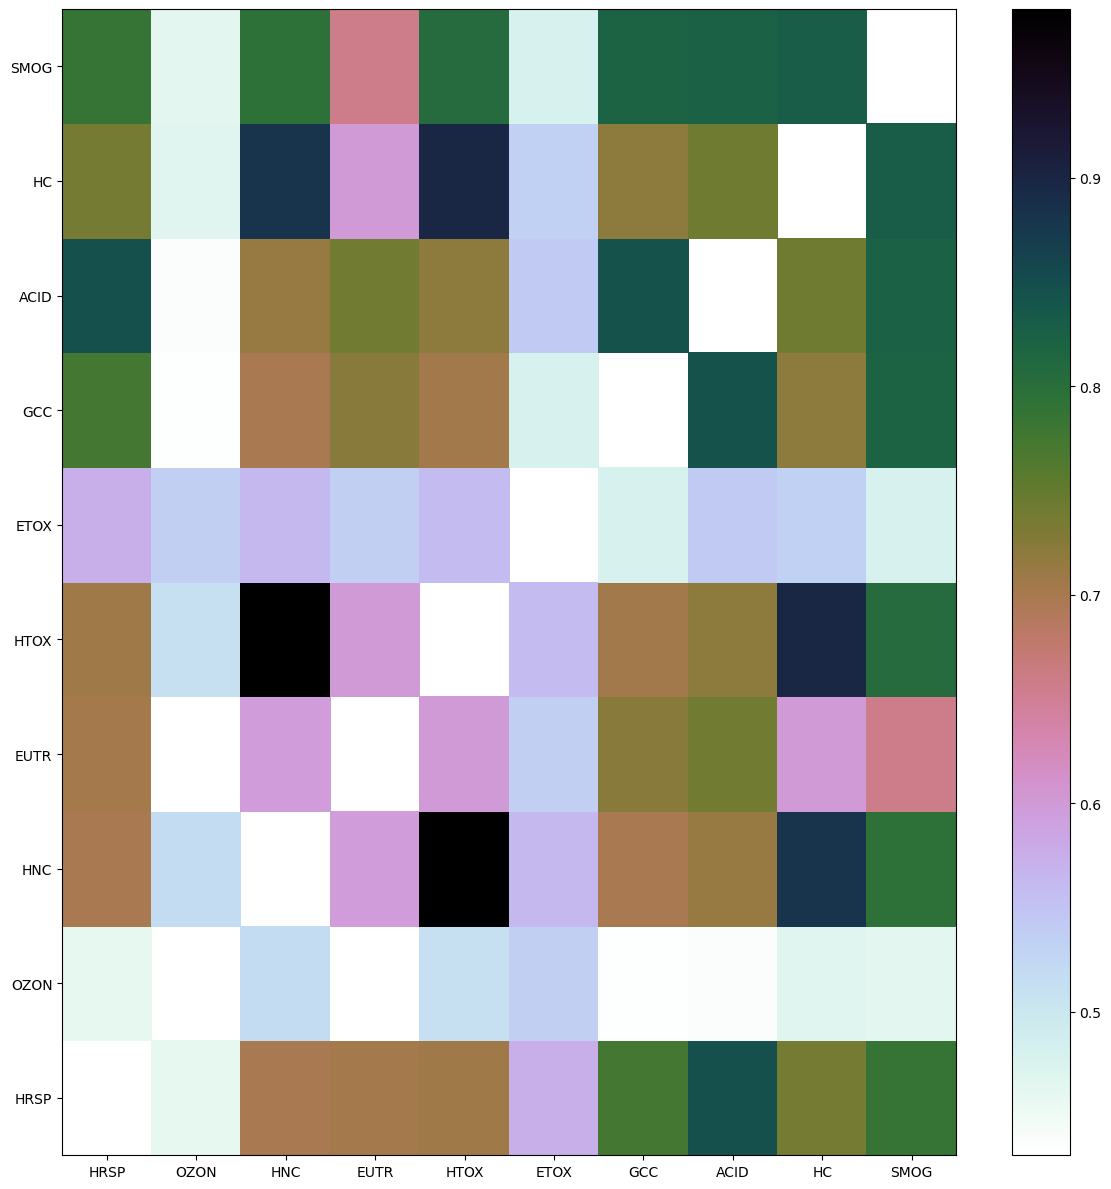

In [174]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 12)

masked_correlation = np.ma.array(correlation_matrix, mask=correlation_matrix == 0).T
plt.pcolor(masked_correlation, cmap=plt.cm.cubehelix_r)
plt.colorbar()
plt.ylim(None, correlation_matrix.shape[1])
plt.xlim(None, correlation_matrix.shape[0])
plt.xticks(np.arange(0.5, 10), [obj[1] for obj in categories_in_order])
plt.yticks(np.arange(0.5, 10), [obj[1] for obj in categories_in_order])
plt.tight_layout()

In [ ]:
for category in categories_in_order:
    print(category[1], bd.methods[category]['description'])